In [1]:
!pip install casadi matplotlib numpy

In [2]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_rotated_rectangle_halfspace(x_center, y_center, width, height, theta):
    """
    Returns halfspace constraints (A, b) for a rotated rectangle.

    Parameters:
    - x_center, y_center: center of the rectangle
    - width, height: size of the rectangle (before rotation)
    - theta: rotation angle in radians (counterclockwise)

    Returns:
    - A, b such that A @ [x, y] <= b
    """
    # Define local (axis-aligned) normals
    A_local = np.array([[1, 0],
                        [-1, 0],
                        [0, 1],
                        [0, -1]])

    # Compute rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])

    # Rotate the normals
    A_rotated = A_local @ R.T  # Rotate normals (transpose because normals transform by inverse transpose)

    # Compute rotated rectangle vertices
    half_w, half_h = width / 2, height / 2
    corners = np.array([[ half_w,  half_h],
                        [-half_w,  half_h],
                        [-half_w, -half_h],
                        [ half_w, -half_h]])

    rotated_corners = (R @ corners.T).T + np.array([x_center, y_center])

    # For each normal, find the maximum dot product over the corners
    b = np.array([np.max(A_rotated[i] @ rotated_corners.T) for i in range(4)])

    return A_rotated, b

In [4]:
def get_rectangle_halfspace(x_center, y_center, width, height):
    # Axis-aligned rectangle
    A = np.array([[ 1, 0],
                  [-1, 0],
                  [0,  1],
                  [0, -1]])
    b = np.array([x_center + width/2,
                 -x_center + width/2,
                  y_center + height/2,
                 -y_center + height/2])
    return A, b

In [5]:
# Dynamics
def f_dyn(x, u):
    xdot = x[3] * ca.cos(x[2])
    ydot = x[3] * ca.sin(x[2])
    thetadot = x[3] / L * ca.tan(u[1])
    vdot = u[0]
    return ca.vertcat(xdot, ydot, thetadot, vdot)

def dyn_obs_trajectory(x_dyn,y_dyn,t):
    # Starts at ego's goal and moves forward in +y direction
    speed = 0.5  # m/s
    x = x_dyn
    y = y_dyn+ speed * t
    return x, y

In [6]:
def add_obca_constraints_opti(opti, X, LAMB, MU, A_list, b_list, ego_shape, dmin):
    """
    Adds OBCA-style obstacle avoidance constraints using ca.Opti().

    Parameters:
    - opti: casadi.Opti instance
    - X: Opti variable (4 x N+1) state trajectory
    - LAMB: Opti variable (total_m x N+1) dual variables for obstacle constraints
    - MU: Opti variable (4*n_obs x N+1) dual variables for ego shape
    - A_list: list of (m x 2) numpy arrays, halfspace normals for each obstacle
    - b_list: list of (m,) numpy arrays, halfspace offsets for each obstacle
    - ego_shape: array of 4 floats, g vector for ego (rectangle with 4 sides)
    - dmin: float, minimum distance
    """
    N = X.shape[1]
    n_obs = len(A_list)
    offset = (ego_shape[0]+ego_shape[2])/2 - ego_shape[2]
    # offset = ego_shape[0]

    g_obs = ca.DM(ego_shape)
    m_list = [A.shape[0] for A in A_list]
    cum_m = np.cumsum([0] + m_list)

    for k in range(N):
        theta_k = X[2, k]
        R = ca.vertcat(
            ca.horzcat(ca.cos(theta_k), -ca.sin(theta_k)),
            ca.horzcat(ca.sin(theta_k), ca.cos(theta_k))
        )

        xk = X[0, k]
        yk = X[1, k]
        t = ca.vertcat(xk + offset * ca.cos(theta_k),
                       yk + offset * ca.sin(theta_k))

        for j in range(n_obs):
            A = ca.DM(A_list[j])
            b = ca.DM(b_list[j])
            m = A.shape[0]
            lamb_jk = LAMB[cum_m[j]:cum_m[j+1], k]
            mu_jk = MU[4*j:4*(j+1), k]

            # Constraint 1: norm(A^T * λ) ≤ 1
            norm_sq = ca.sumsqr(A.T @ lamb_jk)
            opti.subject_to(norm_sq <= 1)

            # Constraint 2: G^T * μ + R^T * A^T * λ = 0
            G_mu = ca.vertcat(-mu_jk[0] + mu_jk[2],
                              -mu_jk[1] + mu_jk[3])
            AT_lambda = A.T @ lamb_jk
            dual_eq = G_mu + R.T @ AT_lambda
            opti.subject_to(dual_eq == 0)

            # Constraint 3: separation ≥ dmin
            A_t = A @ t
            sep = -ca.dot(g_obs, mu_jk) + ca.dot(A_t - b, lamb_jk)
            opti.subject_to(sep >= dmin)

def add_dyn_obca_constraints_opti(opti, X, LAMB_dyn, MU_dyn,n_obs, Len,Wid,t_init,x_goal, ego_shape, dmin):

    N = X.shape[1]
    offset = (ego_shape[0]+ego_shape[2])/2 - ego_shape[2]
    # offset = ego_shape[0]

    g_obs = ca.DM(ego_shape)
    # m_list = [A.shape[0] for A in A_list]
    # cum_m = np.cumsum([0] + m_list)
    x_dyn, y_dyn = dyn_obs_trajectory(x_goal[0],x_goal[1],t_init)

    for k in range(N):
        A_list_dyn=[]
        b_list_dyn=[]
        t_k = dt
        A_dyn, b_dyn = get_rectangle_halfspace(x_dyn, y_dyn, Len, Wid)
        A_list_dyn.append(A_dyn)
        b_list_dyn.append(b_dyn)
        A_list=A_list_dyn
        b_list=b_list_dyn
        x_dyn, y_dyn = dyn_obs_trajectory(x_dyn,y_dyn,t_k)
        m_list = [A.shape[0] for A in A_list]
        cum_m = np.cumsum([0] + m_list)

        theta_k = X[2, k]
        R = ca.vertcat(
            ca.horzcat(ca.cos(theta_k), -ca.sin(theta_k)),
            ca.horzcat(ca.sin(theta_k), ca.cos(theta_k))
        )

        xk = X[0, k]
        yk = X[1, k]
        t = ca.vertcat(xk + offset * ca.cos(theta_k),
                       yk + offset * ca.sin(theta_k))

        for j in range(n_obs):
            A = ca.DM(A_list[j])
            b = ca.DM(b_list[j])
            m = A.shape[0]
            lamb_jk = LAMB_dyn[cum_m[j]:cum_m[j+1], k]
            mu_jk = MU_dyn[4*j:4*(j+1), k]

            # Constraint 1: norm(A^T * λ) ≤ 1
            norm_sq = ca.sumsqr(A.T @ lamb_jk)
            opti.subject_to(norm_sq <= 1)

            # Constraint 2: G^T * μ + R^T * A^T * λ = 0
            G_mu = ca.vertcat(-mu_jk[0] + mu_jk[2],
                              -mu_jk[1] + mu_jk[3])
            AT_lambda = A.T @ lamb_jk
            dual_eq = G_mu + R.T @ AT_lambda
            opti.subject_to(dual_eq == 0)

            # Constraint 3: separation ≥ dmin
            A_t = A @ t
            sep = -ca.dot(g_obs, mu_jk) + ca.dot(A_t - b, lamb_jk)
            opti.subject_to(sep >= dmin)
            # print(sep)


In [7]:
nx = 4 #state variale dimension -- x, y, theta, v
nu = 2 # control var dimension -- a, delta

# Vehicle model
L = 2
W = L/2

# Initial and final state
x_init = np.array([0.0, 0.0, 0.0, 0.0])
# x_goal = np.array([10.0, 0.0, 0.0, 0.0])
x_goal = np.array([9.0, -4.0, np.pi/2, 0.0])

# Time horizon and discretization
# N = 50  # number of control intervals
# T = 10.0  # total time
# dt = T / N
N = 120  # number of control intervals
dt = 0.1 #T / N
T = N*dt

# Cost weights
# Q = np.diag([22, 22, 10, 20])
# Qf = np.diag([22, 22, 10, 20])
# R = np.diag([0.1, 0.1])
Q = np.diag([22, 22, 40, 20])
Qf = np.diag([40, 40, 40, 20])
R = np.diag([0.1, 0.1])

# Optimization problem
opti = ca.Opti()

# Decision variables
X = opti.variable(nx, N+1)
U = opti.variable(nu, N)

# Define the cost function
cost = 0
for k in range(N):
    cost += ca.mtimes((X[:,k] - x_goal).T, Q @ (X[:,k] - x_goal))
    cost += ca.mtimes(U[:,k].T,R @ U[:,k])  # minimize control effort

# Terminal cost
cost += ca.mtimes((X[:,N] - x_goal).T, Qf @ (X[:,N] - x_goal))

opti.minimize(cost)


# Define obstacles
obstacles = [
    (4, -4, 8, 3),   # (x_center, y_center, width, height)
    (14, -4, 8, 3)
]
A_obs1, b_obs1 = get_rectangle_halfspace(*obstacles[0])
A_obs2, b_obs2 = get_rectangle_halfspace(*obstacles[1])
A_list = [A_obs1, A_obs2]
b_list = [b_obs1, b_obs2]


# Adjust total dual variables for static and dynamic obstacles
n_obs_static = len(A_list) #1 obstacle
total_m = sum(A.shape[0] for A in A_list)
LAMB = opti.variable(total_m, N+1)
MU   = opti.variable(nx * n_obs_static, N+1)

n_obs_dyn = 1
total_m_dyn= A_list[0].shape[0]
LAMB_dyn = opti.variable(total_m_dyn, N+1)
MU_dyn   = opti.variable(nx * n_obs_dyn, N+1)

# Bounds
# v_min, v_max = -10.0, 10.0
# a_min, a_max = -2.0, 2.0
v_min, v_max = -1.0, 2.0
a_min, a_max = -1.0, 1.0
delta_min, delta_max = -1, 1

for k in range(N+1):
    opti.subject_to(X[3,k] >= v_min)
    opti.subject_to(X[3,k] <= v_max)

for k in range(N):
    opti.subject_to(U[0,k] >= a_min)
    opti.subject_to(U[0,k] <= a_max)
    opti.subject_to(U[1,k] >= delta_min)
    opti.subject_to(U[1,k] <= delta_max)

# Dynamics constraints
for k in range(N):
    x_next = X[:,k] + dt * f_dyn(X[:,k], U[:,k])
    opti.subject_to(X[:,k+1] == x_next)

# Initial condition
opti.subject_to(X[:,0] == x_init)
# opti.subject_to(X[:,-1] == x_goal)

# add obstacle constraint
add_obca_constraints_opti(opti, X, LAMB, MU, A_list, b_list, ego_shape=[L/2, W/2, L/2, W/2], dmin=0.1) # full dimensional
# add_obca_constraints_opti(opti, X, LAMB, MU, A_list, b_list, ego_shape=[0.0, 0.0, 0.0, 0.0], dmin=0.3) # point mass

#### Add OBCA constraints with combined obstacle set
t_sim=0
add_dyn_obca_constraints_opti(opti, X, LAMB_dyn, MU_dyn,n_obs_dyn, W,L,t_sim,x_goal, ego_shape=[L/2, W/2, L/2, W/2], dmin=0.1)


opti.subject_to(ca.vec(LAMB) >= 0)
opti.subject_to(ca.vec(MU) >= 0)
opti.subject_to(ca.vec(LAMB_dyn) >= 0)
opti.subject_to(ca.vec(MU_dyn) >= 0)

# Initial guess (linear interpolation)
x_guess = np.zeros((4, N+1))
u_guess = np.zeros((2, N))
for k in range(N+1):
    x_guess[:,k] = x_init + (x_goal - x_init) * k / N
opti.set_initial(X, x_guess)
opti.set_initial(U, u_guess)

# Solver setup
opts = {
    'ipopt': {
        'print_level': 0,
        'max_iter': 500,
        'tol': 1e-6,
        'acceptable_tol': 1e-4
    }
}
opti.solver('ipopt', opts)

# Solve
sol = opti.solve()

# Extract solution
X_opt = sol.value(X)
U_opt = sol.value(U)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  12.97ms ( 79.55us)  12.98ms ( 79.65us)       163
       nlp_g  | 132.57ms (813.31us) 132.43ms (812.46us)       163
  nlp_grad_f  |  15.64ms ( 96.55us)  15.65ms ( 96.58us)       162
  nlp_hess_l  | 490.60ms (  3.09ms) 490.84ms (  3.09ms)       159
   nlp_jac_g  | 395.57ms (  2.43ms) 395.81ms (  2.43ms)       163
       total  |   5.13 s (  5.13 s)   5.13 s (  5.13 s)         1


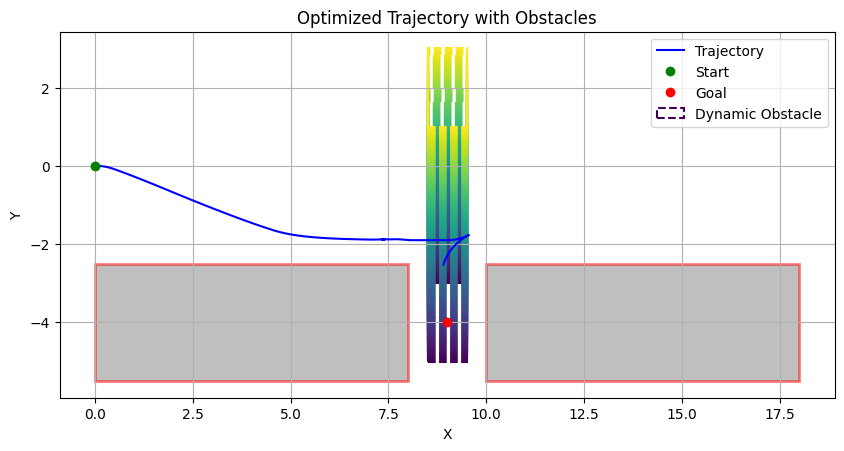

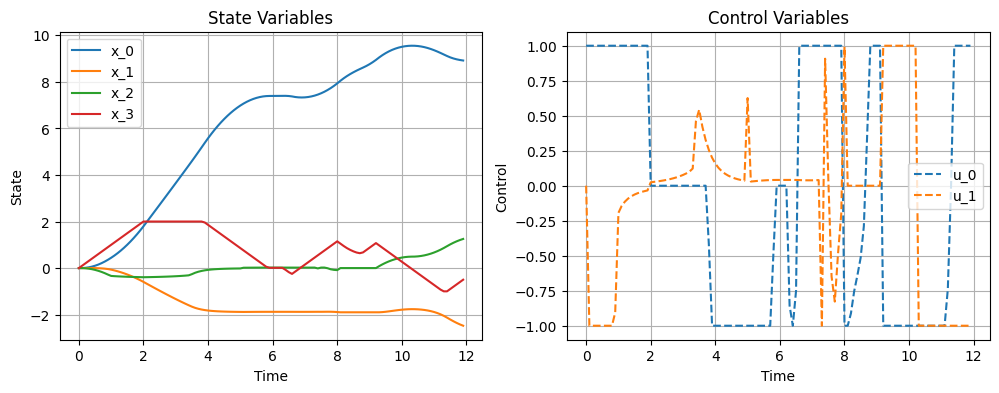

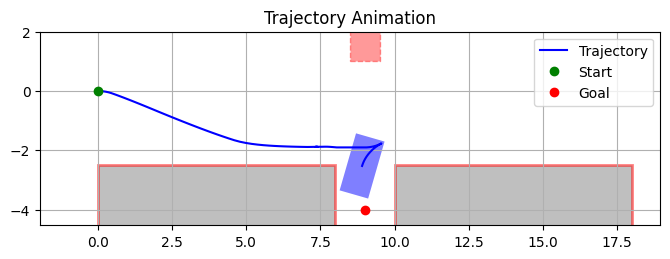

/var/folders/z0/3frv2l990hb5ryd49z8vm4w80000gn/T/ipykernel_7122/124526758.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


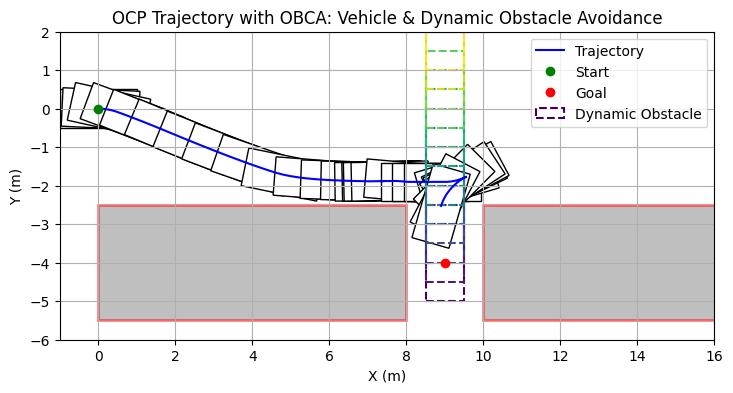

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(10, 6))

# Plot trajectory, start, and goal
ax.plot(X_opt[0, :], X_opt[1, :], 'b-', label='Trajectory')
ax.plot(x_init[0], x_init[1], 'go', label='Start')
ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')

# Define colormap and normalize over [0, T]
cmap = cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=T)

# Plot static obstacles
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = patches.Rectangle((x_c - w/2, y_c - h/2), w, h,
                             linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    ax.add_patch(rect)

# Plot dynamic obstacle at several time steps
for k in range(0, N+1):# [0, N]: #range(0, N+1):  # every 5 time steps
    t_k = k * dt
    x_dyn, y_dyn = dyn_obs_trajectory(x_goal[0],x_goal[1],t_k)
    color = cmap(norm(t_k))  # get color based on time
    rect_dyn = patches.Rectangle((x_dyn - W/2, y_dyn - L/2), W,L,
                                 linewidth=1.5, edgecolor=color, linestyle='--',
                                 facecolor='none', label='Dynamic Obstacle' if k == 0 else "")
    ax.add_patch(rect_dyn)

# Final formatting
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Optimized Trajectory with Obstacles')
ax.legend()
ax.grid(True)

plt.show()

t_eval = np.arange(0, T, dt)

# Create a figure
plt.figure(figsize=(12, 4))

# Plot the state variables
plt.subplot(1, 2, 1)
for k in range(4):
    plt.plot(t_eval, X_opt[k,:-1], label=f"x_{k}")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")
plt.title("State Variables")

# Plot the control variables
plt.subplot(1, 2, 2)
for k in range(2):
    plt.plot(t_eval, U_opt[k,:], linestyle="--", label=f"u_{k}")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")
plt.title("Control Variables")
plt.show()

from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Car dimensions
car_length = L
car_width = W

# Set up figure
fig, ax = plt.subplots(figsize=(8, 8))
# ax.set_xlim(np.min(X_opt[0, :]) - 2, np.max(X_opt[0, :]) + 2)
ax.set_ylim(np.min(X_opt[1, :]) - 2, np.max(X_opt[1, :]) + 2)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title("Trajectory Animation")

# Initialize plot elements
trajectory_line, = ax.plot([], [], 'b-', label='Trajectory')
start_point = ax.plot(x_init[0], x_init[1], 'go', label='Start')[0]
goal_point = ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')[0]

# Ego car patch
car_patch = Rectangle((-car_length / 2, -car_width / 2), car_length, car_width,
                      facecolor='blue', alpha=0.5)
ax.add_patch(car_patch)

# Dynamic obstacle patch (initially placed at 0,0; updated later)
dyn_patch = Rectangle((-car_width / 2, -car_length / 2), car_width, car_length,
                      facecolor='red', alpha=0.4, linestyle='--', edgecolor='red')
ax.add_patch(dyn_patch)

# Plot static obstacles
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                     linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    ax.add_patch(rect)

ax.legend()

def update(frame):
    # Ego car pose
    x, y, theta = X_opt[0, frame], X_opt[1, frame], X_opt[2, frame]
    trajectory_line.set_data(X_opt[0, :frame+1], X_opt[1, :frame+1])
    car_transform = Affine2D().rotate(theta).translate(x, y) + ax.transData
    car_patch.set_transform(car_transform)

    # Dynamic obstacle pose
    t_k = frame * dt
    x_dyn, y_dyn = dyn_obs_trajectory(x_goal[0],x_goal[1],t_k)
    dyn_transform = Affine2D().translate(x_dyn, y_dyn) + ax.transData
    dyn_patch.set_transform(dyn_transform)

    return trajectory_line, car_patch, dyn_patch

# Animate
ani = animation.FuncAnimation(fig, update, frames=X_opt.shape[1],
                              interval=100, blit=True)

# Save as GIF
ani.save("trajectory.gif", writer='pillow', fps=10)

plt.show()

# --- Merged static and dynamic obstacle trajectory plot ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(X_opt[0, :], X_opt[1, :], 'b-', label='Trajectory')
ax.plot(x_init[0], x_init[1], 'go', label='Start')
ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')

# Static obstacles
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                     linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    ax.add_patch(rect)

# Vehicle shape visualization every few steps
for i in range(0, N+1, 4):
    veh_pose = Rectangle((X_opt[0, i] - L/2, X_opt[1, i] - W/2), L, W,
                         facecolor='white', edgecolor='black', alpha=1)
    trans = Affine2D().rotate_deg_around(X_opt[0, i], X_opt[1, i], np.rad2deg(X_opt[2, i])) + ax.transData
    veh_pose.set_transform(trans)
    ax.add_patch(veh_pose)

# Dynamic obstacle trajectory visualization
from matplotlib import cm
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=N * dt)
cmap = cm.get_cmap('viridis')

for k in range(0, N+1, 10):  # every 10 time steps
    t_k = k * dt
    x_dyn, y_dyn = dyn_obs_trajectory(x_goal[0], x_goal[1], t_k)
    color = cmap(norm(t_k))  # color based on time
    rect_dyn = Rectangle((x_dyn - W/2, y_dyn - L/2), W, L,
                         linewidth=1.5, edgecolor=color, linestyle='--',
                         facecolor='none', label='Dynamic Obstacle' if k == 0 else "")
    ax.add_patch(rect_dyn)

# Final plot settings
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_ylim(-6, 2)
ax.set_xlim(-1, 16)
ax.grid(True)
ax.set_aspect('equal')
ax.set_title("OCP Trajectory with OBCA: Vehicle & Dynamic Obstacle Avoidance")
ax.legend()
plt.show()
fig.clf()
plt.close(fig)